In [24]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.nn.functional as F

from src.data_processing.dataset_builder import preprocess_data

In [2]:
### prepare dataloader for mlp and multi-logistic regression
# dataloader for training mlp : batch_szie = 512
train_dataloader, valid_dataloader, test_dataloader = preprocess_data('data/standardized', batch_size = 512).get_dataloader()
# dataloader for training multi-logistic regression and validating and testing  : batch_szie = len(dataset)
logi_train_dataloader, logi_valid_dataloader, logi_test_dataloader = preprocess_data('data/standardized').get_dataloader()

### make a quick fetch of dataloader.
def get_one(x): return next(iter(x))


Label distribution:
Label     Train     Valid     Test      
----------------------------------------
0         1296      280       264       
1         1334      290       296       
2         11261     2419      2425      
3         669       131       135       

Total samples:
Train     14560     
Valid     3120      
Test      3120      


### train logistic regression

In [4]:
logi_re = LogisticRegression(penalty='l2')

In [30]:
x, y = get_one(logi_train_dataloader)
logi_re.fit(x, y)
valid_x, valid_y = get_one(logi_valid_dataloader)
pred_valid_y = logi_re.predict(valid_x)
test_x, test_y = get_one(logi_test_dataloader)
pred_test_y = logi_re.predict(test_x)

valid_score = accuracy_score(valid_y, pred_valid_y)
test_score = accuracy_score(test_y, pred_test_y)
print(f'valid_accuracy_score : {valid_score}, test_accuracy_score : {test_score}')

valid_accuracy_score : 0.5486271915315911, test_accuracy_score : 0.5664081834680745


c:\Users\DELL\.conda\envs\finrl\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### logistic regression confusion matrix visualization

     预测正例	   预测负例
实际正例	      TP	         FN

实际负例	      FP	         TN

<Axes: >

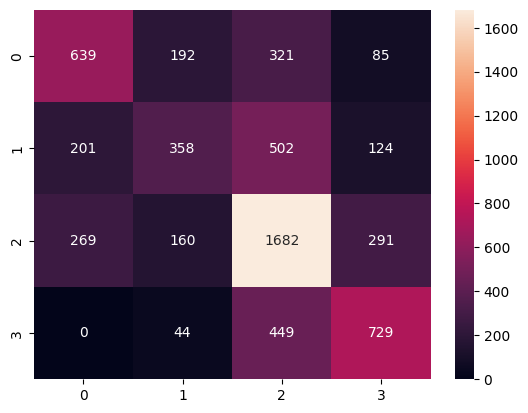

In [28]:
sns.heatmap(confusion_matrix(valid_y, pred_valid_y), annot=True, fmt='d')

<Axes: >

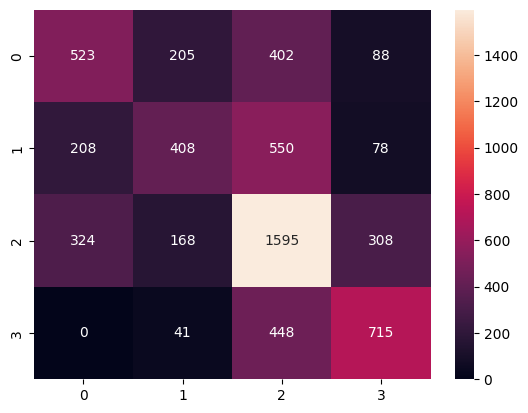

In [27]:
sns.heatmap(confusion_matrix(test_y, pred_test_y), annot=True, fmt='d')

In [16]:
logi_re.coef_.shape, logi_re.coef_

((4, 11),
 array([[-8.33488440e-01,  3.19860113e-02,  2.59930397e-02,
          4.86757879e-02,  1.00596791e-02,  6.64048063e-03,
          1.97065328e-02,  2.64097409e-03,  9.29233785e-03,
         -4.97584322e-02,  9.86364862e-04],
        [-1.52227353e-01, -1.62183925e-02, -4.23449867e-02,
          8.49717254e-02,  1.36388203e-02, -3.85013215e-02,
          3.31693920e-02, -2.34512277e-03,  3.01340787e-02,
          1.50850599e-02, -1.12324826e-02],
        [-9.81461837e-02,  1.14853371e-03, -2.32220295e-02,
         -1.50889407e-02, -6.13019793e-03, -1.32702832e-01,
         -3.64652296e-03, -1.01376113e-02, -4.72353009e-03,
          2.71519267e-02,  2.27852715e-02],
        [ 1.08386198e+00, -1.69161525e-02,  3.95739765e-02,
         -1.18558573e-01, -1.75683015e-02,  1.64563673e-01,
         -4.92294019e-02,  9.84175997e-03, -3.47028864e-02,
          7.52144561e-03, -1.25391538e-02]]))

### construct a MLP for classification

In [10]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(11, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 5)
            )
    def forward(self, x):
        return self.seq(x)

### train MLP and evaluate

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loss_list = valid_loss_list = test_loss_list = []
model = MLP().to(device)
model_loss = nn.CrossEntropyLoss()
model_optizer = torch.optim.AdamW(model.parameters(), lr=0.01)
def train_mlp_model(model, epoch=1500):
    model.train()
    for epoch in range(1, epoch + 1):
        x, y = get_one(train_dataloader)
        x, y = x.to(device), y.to(device)
        model_optizer.zero_grad()
        y_pre = model(x)
        loss = model_loss(y_pre, torch.tensor(y, dtype=torch.long))
        loss.backward()
        model_optizer.step()
        valid_loss = valid_mlp_model(model)
        train_loss_list.append(loss.cpu().detach().numpy())
        valid_loss_list.append(valid_loss)
        print(f'Epoch: {epoch}, train_Loss: {loss.item()}, valid_Loss: {valid_loss}')
def valid_mlp_model(model):
    model.eval()
    with torch.no_grad():
        x, y = get_one(valid_dataloader)
        x, y = x.to(device), y.to(device)
        y_pre = model(x)
        loss = model_loss(y_pre, torch.tensor(y, dtype=torch.long))
        return loss.item()

train_mlp_model(model)

C:\Users\DELL\AppData\Local\Temp\ipykernel_27512\3296797629.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = model_loss(y_pre, torch.tensor(y, dtype=torch.long))
C:\Users\DELL\AppData\Local\Temp\ipykernel_27512\3296797629.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = model_loss(y_pre, torch.tensor(y, dtype=torch.long))


Epoch: 1, train_Loss: 1.735280990600586, valid_Loss: 1.6161590814590454
Epoch: 2, train_Loss: 1.5815836191177368, valid_Loss: 1.4084564447402954
Epoch: 3, train_Loss: 1.4807461500167847, valid_Loss: 1.3527183532714844
Epoch: 4, train_Loss: 1.302480697631836, valid_Loss: 1.2926784753799438
Epoch: 5, train_Loss: 1.2836672067642212, valid_Loss: 1.2802255153656006
Epoch: 6, train_Loss: 1.2672042846679688, valid_Loss: 1.2611716985702515
Epoch: 7, train_Loss: 1.2472749948501587, valid_Loss: 1.2563936710357666
Epoch: 8, train_Loss: 1.170182228088379, valid_Loss: 1.2269550561904907
Epoch: 9, train_Loss: 1.1824814081192017, valid_Loss: 1.1951162815093994
Epoch: 10, train_Loss: 1.1632832288742065, valid_Loss: 1.1812373399734497
Epoch: 11, train_Loss: 1.0931425094604492, valid_Loss: 1.176072359085083
Epoch: 12, train_Loss: 1.1151602268218994, valid_Loss: 1.157837986946106
Epoch: 13, train_Loss: 1.0513169765472412, valid_Loss: 1.1706486940383911
Epoch: 14, train_Loss: 1.208234190940857, valid_Loss

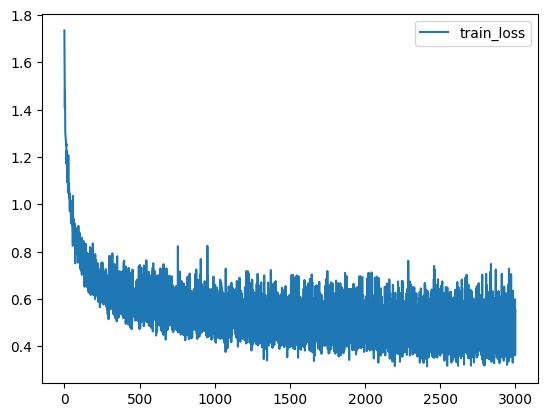

In [63]:
plt.plot(train_loss_list, label='train_loss')
plt.legend()

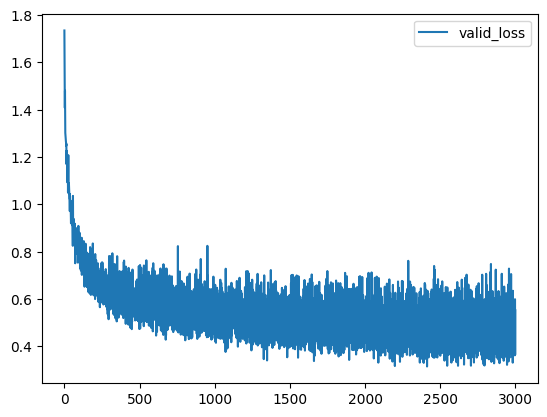

In [64]:
plt.plot(valid_loss_list, label='valid_loss')
plt.legend()

In [61]:

x, y = get_one(logi_train_dataloader)
valid_x, valid_y = get_one(logi_valid_dataloader)
valid_x, valid_y = valid_x.to(device), valid_y.to(device)
pred_valid_y = model(valid_x)
test_x, test_y = get_one(logi_test_dataloader)
test_x, test_y = test_x.to(device), test_y.to(device)
pred_test_y = model(test_x)

valid_score = accuracy_score(valid_y.cpu().detach().numpy(), torch.max(F.softmax(pred_valid_y, dim=1), 1)[1].cpu().detach().numpy())
test_score = accuracy_score(test_y.cpu().detach().numpy(), torch.max(F.softmax(pred_test_y, dim=1), 1)[1].cpu().detach().numpy())
print(f'valid_accuracy_score : {valid_score}, test_accuracy_score : {test_score}')

valid_accuracy_score : 0.785643400595435, test_accuracy_score : 0.7955782874113183


<Axes: >

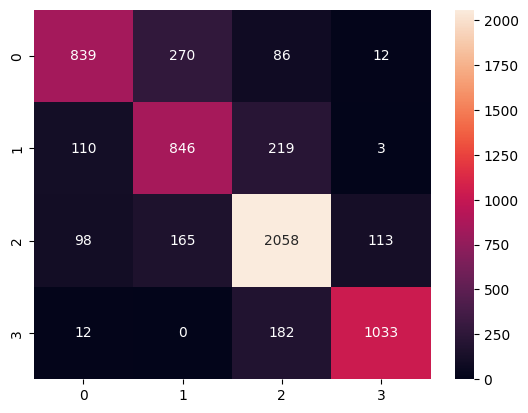

In [56]:
sns.heatmap(confusion_matrix(valid_y.cpu().detach().numpy(), torch.max(F.softmax(pred_valid_y, dim=1), 1)[1].cpu().detach().numpy()), annot=True, fmt='d')

<Axes: >

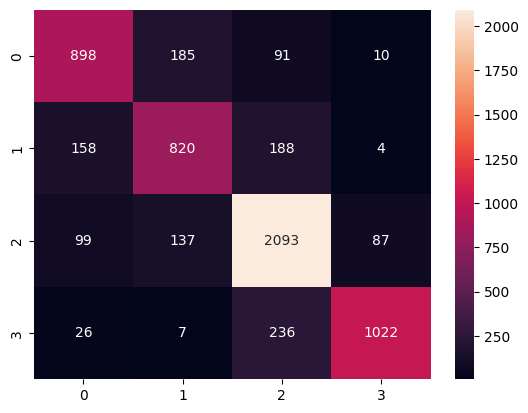

In [60]:
sns.heatmap(confusion_matrix(test_y.cpu().detach().numpy(), torch.max(F.softmax(pred_test_y, dim=1), 1)[1].cpu().detach().numpy()), annot=True, fmt='d')